# Building the Classifier

This notebook is made to evaluate classifier performance by splitting the available annotated "training" data of the challenge into train in test splits and trying different things.

In [10]:
import pickle
import pandas as pd
import numpy as np
from os.path import join

from sklearn import svm
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## 0. Set parameters

In [11]:
#HEIGHT, WIDTH, CHANNELS = 224, 224, 3
HEIGHT, WIDTH, CHANNELS = 128, 128, 3
POOLING_METHOD = 'avg'
model_name = 'mobilenet'

### Load all available training features into one big dataframe

In [14]:
sets = [('colombia', 'borde_rural'),
        ('colombia', 'borde_soacha'),
        ('guatemala', 'mixco_1_and_ebenezer'), 
        ('guatemala', 'mixco_3'),
        ('st_lucia', 'dennery')
        #('st_lucia', 'gros_islet'), 
        #('st_lucia', 'castries')
       ]
country, region = sets[3]
pickle_path = join('..', '..', 'features')

In [16]:
with open(join(pickle_path, f'{model_name}_{HEIGHT}_{POOLING_METHOD}_{region}_train.pkl' ), 'rb') as f:
    features_train = pickle.load(f)

In [3]:
columns = ['id', 'features', 'label']
df_train_global = pd.DataFrame(columns=columns)

pickle_path = join('..', '..', 'pickles')
for region in regions:
    try:
        with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl'), 'rb') as f:
            df_train = pickle.load(f)
            df_train_global = pd.concat([df_train_global, df_train], ignore_index=True)
    except:
        print("Error reading training data for region ", region)
    

Error reading training data for region  borde_rural
Error reading training data for region  borde_soacha
Error reading training data for region  mixco_1_and_ebenezer
Error reading training data for region  mixco_3
Error reading training data for region  dennery


In [12]:
df_train_global.head()
df_train_global = df_train_global.sort_values(by=['id'])

### Expand the dataframe such that instead of a list of features, every feature has its one column

In [13]:
feature_matrix_global = df_train_global['features'].to_numpy()
feature_matrix_global = np.column_stack(feature_matrix_global).transpose()

labels_global = df_train_global['label'].to_numpy().astype('int')

In [14]:
scaler = StandardScaler()
scaler.fit(feature_matrix_global)
feature_matrix_scaled = scaler.transform(feature_matrix_global)

In [15]:
print(feature_matrix_global.shape)
print(labels_global.shape)

(14852, 2048)
(14852,)


### Split into training and test set

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_global,
                                                                            labels_global,
                                                                            test_size=0.33,
                                                                            random_state=42)

## Random Forest Classifiation

In [23]:
forest = RandomForestClassifier(n_estimators=500, max_depth=16, random_state=0, n_jobs=6)
forest.fit(features_train, labels_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=6,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Evaluate performance

In [16]:
pred_probas = forest.predict_proba(features_test)
log_l = log_loss(labels_test, pred_probas)
log_l

0.7085974449252996

In [20]:
cv_results = cross_validate(forest, feature_matrix_global, labels_global,
                            cv=5, scoring=('f1_macro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=6)

In [21]:
avg_f1_macro = np.mean(cv_results['test_f1_macro'])
avg_accuracy = np.mean(cv_results['test_accuracy'])
print("Average F1 macro: ", avg_f1_macro)
print("Average Accuracy: ", avg_accuracy)

Average F1 macro:  0.447617520803277
Average Accuracy:  0.756461723744578


In [24]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}
predicted_labels = forest.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

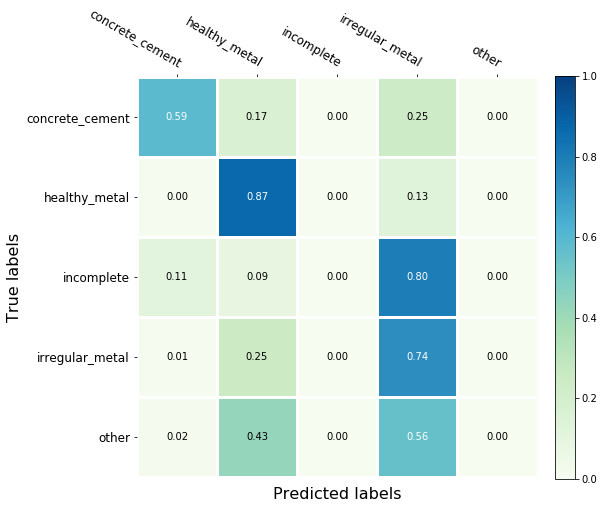

In [26]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm_rf.png')
fig.savefig(fname)

## Support Vector Machine Classification

(Optional): Use the top-x features of the Random Forest model for SVM training. Thereby reduce training time while compromising accuracy only very little.

In [ ]:
top_x = 200

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][top_x]
feature_matrix_selected = feature_matrix_global[:, indices]

When splitting into training and test set, choose `feature_matrix_global` for full features or `feature_matrix_selected`for the top x features from RF.

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_global,
                                                                            labels_global,
                                                                            test_size=0.33,
                                                                            random_state=42)

Train the classifier

In [17]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Visualize results in confusion matrix

In [18]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

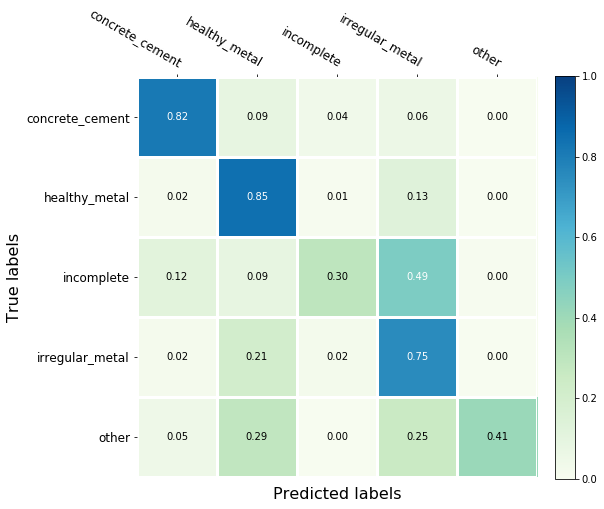

In [21]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm_svm.png')
fig.savefig(fname)

Evaluate performance in terms of log loss and other scores

In [34]:
pred_probas = clf.predict_proba(features_test)
log_l = log_loss(labels_test, pred_probas)
log_l

0.5702804204868949

In [35]:
cv_results = cross_validate(clf, feature_matrix_selected, labels_global,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=7)

In [36]:
cv_results

{'fit_time': array([228.25653768, 226.47934437, 226.06283188, 231.13135171,
        224.69854426]),
 'score_time': array([30.50028276, 30.00723219, 30.31440639, 30.58100104, 29.82408643]),
 'test_f1_macro': array([0.62294524, 0.63484941, 0.64512324, 0.6325258 , 0.61330979]),
 'test_f1_micro': array([0.76009421, 0.7512622 , 0.76203299, 0.77265072, 0.75682048]),
 'test_accuracy': array([0.76009421, 0.7512622 , 0.76203299, 0.77265072, 0.75682048]),
 'test_balanced_accuracy': array([0.59975709, 0.61482238, 0.61539199, 0.60200348, 0.59499513])}

In [20]:
avg_accuracy = np.mean([0.76009421, 0.7512622 , 0.76203299, 0.77265072, 0.75682048])
avg_f1_macro = np.mean([0.62294524, 0.63484941, 0.64512324, 0.6325258 , 0.61330979])

In [21]:
print(avg_accuracy, avg_f1_macro)

0.7605721200000001 0.629750696


## Evaluate Performance of RF classifier